In [13]:
# === Imports ===
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from utils import ContactPredictor, ProteinDataset
from torch.utils.data import DataLoader

# === Configuration ===
MODEL_PATH = "results/runs_pairwise/contact_predictor.pth"  # path to your trained model
EMB_DIR = "embeddings/enriched_embeddings_pairwise/test"           # path to test embeddings (.pt)
PDB_DIR = "protein_data/test"                           # path to test pdb directory
MAX_RESIDUES = 1000
NUM_SAMPLES = 5                                     # number of test proteins to visualize
HIDDEN_DIM = 16 # the hidden dim used during training

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

Using device: cpu


In [14]:
# === Load test dataset ===
test_dataset = ProteinDataset(
    pdb_dir=PDB_DIR,
    emb_dir=EMB_DIR,
    max_residues=MAX_RESIDUES
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# === Load trained model ===
# get embedding dimension from one sample
sample_emb = torch.load(
    os.path.join(EMB_DIR, test_dataset.files[0] + ".pt"), weights_only=True
)
emb_dim = sample_emb.shape[1]

model = ContactPredictor(emb_dim=emb_dim, hidden_dim=HIDDEN_DIM).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE, weights_only=True))
model.eval()

print(f"Loaded model with emb_dim={emb_dim} and {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")

Loaded model with emb_dim=72 and 2,337 trainable parameters


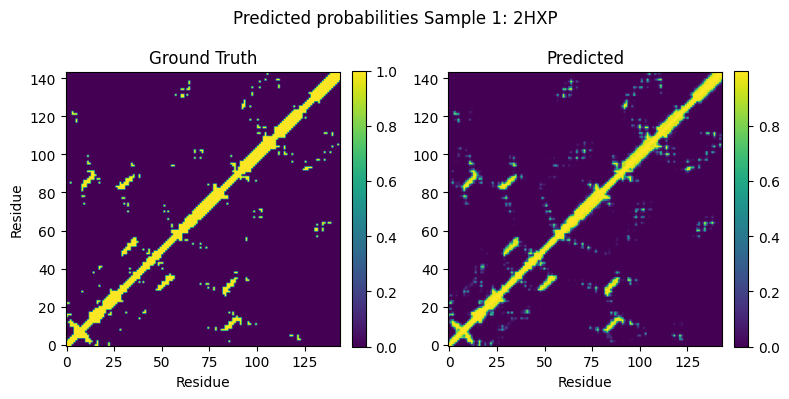

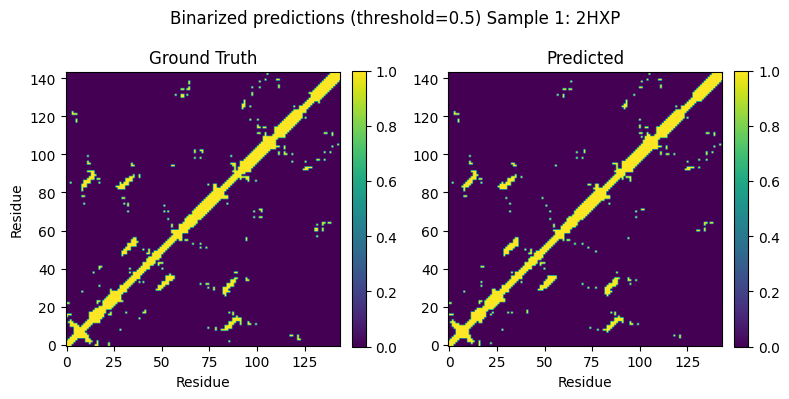

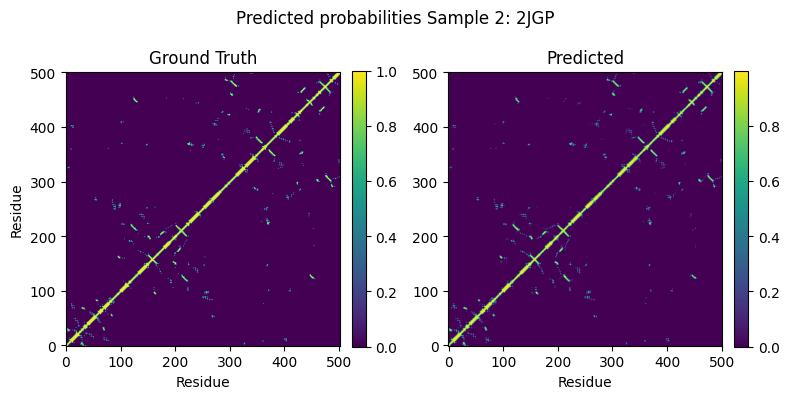

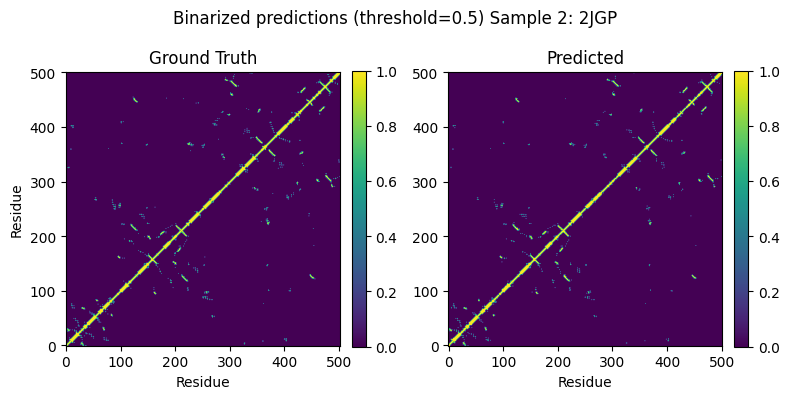

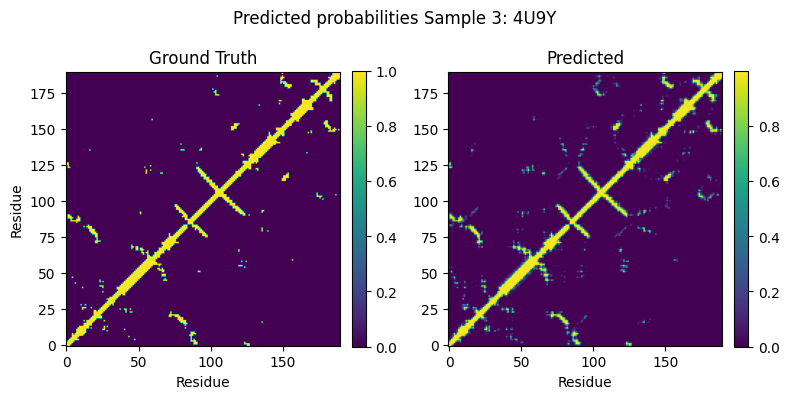

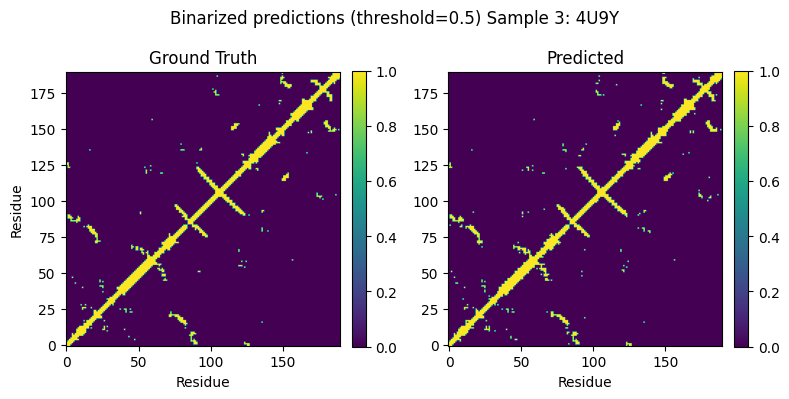

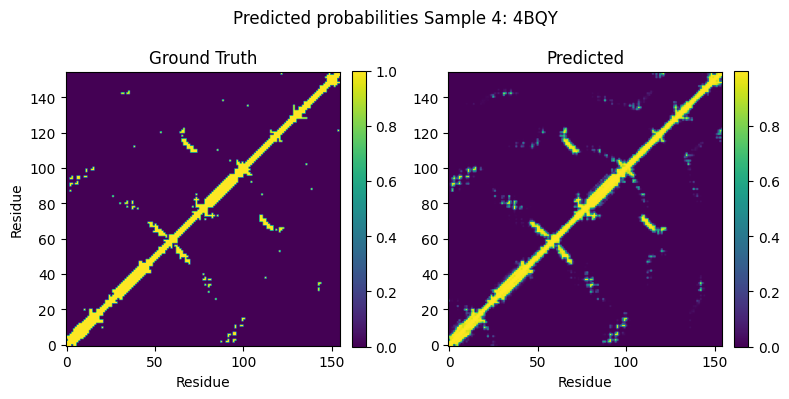

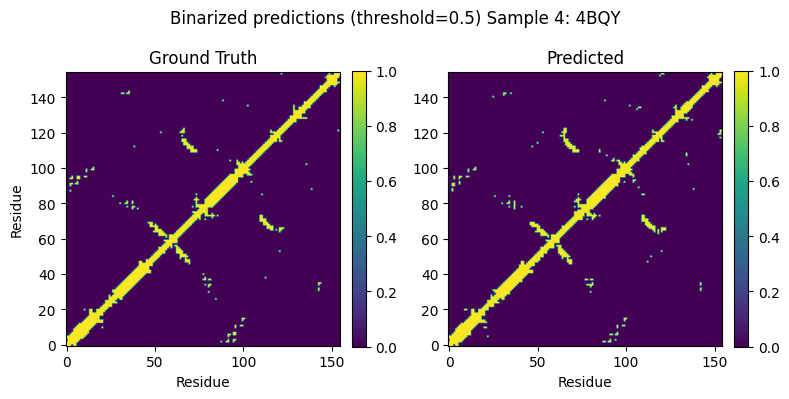

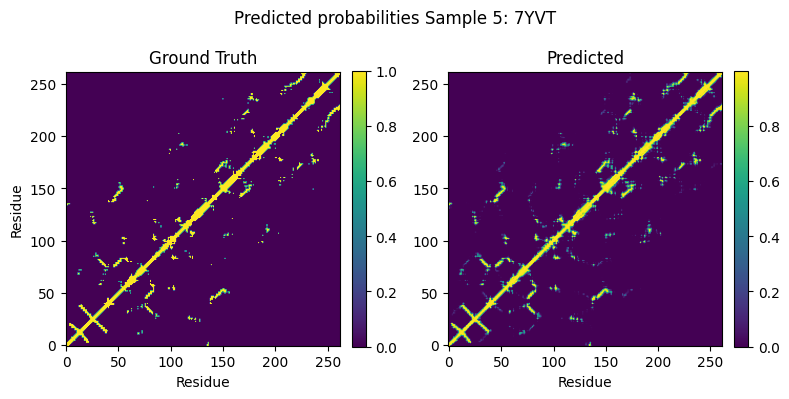

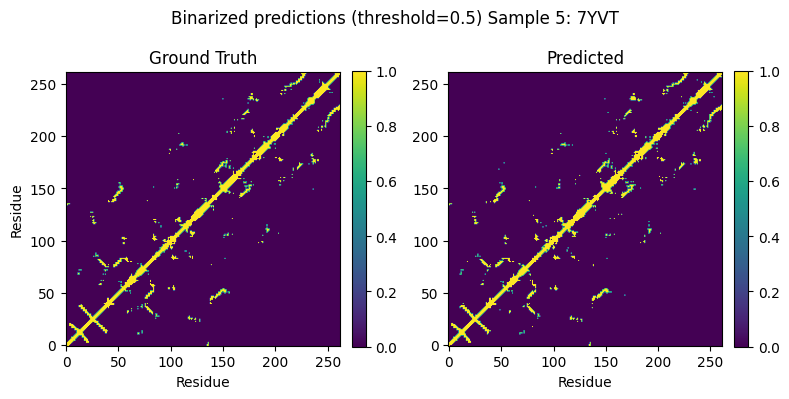

Done!


In [15]:
# === Visualization function ===
def plot_contact_maps(true_map, pred_map, save_path, title=""):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    im0 = axes[0].imshow(true_map, cmap="viridis", origin="lower")
    axes[0].set_title("Ground Truth")
    axes[0].set_xlabel("Residue")
    axes[0].set_ylabel("Residue")
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    im1 = axes[1].imshow(pred_map, cmap="viridis", origin="lower")
    axes[1].set_title("Predicted")
    axes[1].set_xlabel("Residue")
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

save_path = "results/runs_pairwise/plots"
# === Run inference and visualize ===
with torch.no_grad():
    for i, (emb, true_contact) in enumerate(test_loader):
        if i >= NUM_SAMPLES:
            break

        emb = emb[0].to(DEVICE)
        true_contact = true_contact[0].cpu().numpy()
        probs = torch.sigmoid(model(emb)).cpu().numpy()
        binary = (probs > 0.5).astype(float)


        # ensure same shape
        L = min(true_contact.shape[0], probs.shape[0])
        true_contact = true_contact[:L, :L]
        probs = probs[:L, :L]
        binary = binary[:L, :L]

        plot_contact_maps(true_contact, probs, os.path.join(save_path, f"sigmoid_map_{test_dataset.files[i]}.png"), 
                          title=f"Predicted probabilities Sample {i+1}: {test_dataset.files[i]}")
        plot_contact_maps(true_contact, binary, os.path.join(save_path, f"binary_map_{test_dataset.files[i]}.png"),
                          title=f"Binarized predictions (threshold=0.5) Sample {i+1}: {test_dataset.files[i]}")

print("Done!")
